# Understanding molecular bases of drug response and drug synergy
Understanding synergistic effects of drugs is key to develop effective intervention strategies targeting diseases (such as AD or T2D or both) and provides unprecedented opportunities to repurpose existing drugs. The AstraZeneca-Sanger Drug Combination Prediction DREAM Challenge provides a rich data source aiming to understand the synergistic drug behavior based on pretreatment data and spans cell viability data over 118 drugs and 85 cancer cell lines (primarily colon, lung, and breast). In collaborating with Dr. Baldo Oliva's group at GRIB, UPF-IMIM, we have been working on identifying the effects of confounding factors in the data set such as dosage and genetic background of the cell lines and developing algorithms that can predict the individual and synergistic effects of drugs. 

The challenge has two subtasks: predicting drug synergy *(i)* using mono synergy data *(ii)* without using mono synergy data. The participants are free to use any other data source (such as cell line gene expression, gene mutation, drug target information provided  in the challenge or external data sets) and submit their predictions in 3 rounds. 

<For the first round of the challenge, we have build machine learning models to predict the synergy of drugs for both of these tasks and choice the best performing models to submit predictions. Among various machine learning models, we found a combination of bootstrapped and ensemble tree-based predictors achieved best performance on the training data set for. 

To improve the prediction performance we have incorporated mutation data (of drug targets in a given cell line) and interactome based contribution of the drug combination compared to the effect of drugs separately. To assess interactome based contribution of a drug or combination (characterized by a set of targets), we have used GUILD, a network-based functional prioritization tool. 

Interestingly, using GUILD, only the predictions for subtask *(ii)* improved but not for subtask *(i)*. We suspect this is due to the mono therapy response data describing the synergy best and addition of new features (such as the ones based on expression, mutation, interactome) potentially causing the predictor to overfit to the training data set.>

## Data overview

In [21]:
data.dir = "../data/"
output.dir = "../doc/"
set.seed(142341)
# Data overview
file.name = "Drug_synergy_data/ch1_train_combination_and_monoTherapy.csv"
f = read.csv(paste0(data.dir, file.name))
summary(f)
print(sprintf("Number of samples: %d", nrow(f))) 

      CELL_LINE          COMPOUND_A       COMPOUND_B     MAX_CONC_A    
 CAMA-1    :  64   AKT        : 243   PIK3C    : 227   Min.   : 0.003  
 MDA-MB-468:  59   IAP        : 152   MTOR_1   : 220   1st Qu.: 1.000  
 HCC1187   :  57   AKT_1      : 151   MAP2K_1  : 198   Median : 1.000  
 HCC1395   :  56   BCL2_BCL2L1: 121   FGFR     : 156   Mean   : 1.721  
 HCC70     :  54   MAP2K_1    : 121   IAP      :  89   3rd Qu.: 3.000  
 MDA-MB-453:  52   ATR_4      : 107   CSNK2A1_2:  75   Max.   :10.000  
 (Other)   :1857   (Other)    :1304   (Other)  :1234                   
   MAX_CONC_B         IC50_A               H_A              Einf_A      
 Min.   : 0.003   Min.   : 0.000003   Min.   : 0.0000   Min.   :  0.00  
 1st Qu.: 1.000   1st Qu.: 0.072514   1st Qu.: 0.4777   1st Qu.: 11.82  
 Median : 1.000   Median : 0.344153   Median : 1.3273   Median : 42.90  
 Mean   : 4.956   Mean   : 0.731751   Mean   : 3.1060   Mean   : 46.72  
 3rd Qu.: 3.000   3rd Qu.: 1.000000   3rd Qu.: 3.6625   3rd

[1] "Number of samples: 2199"


## Data cleaning

- Filter samples with low quality (404 samples):
$$QA < 1$$

Both min (-588.221) and max (6737.175) synergy instances have low quality (see the summary above). After this filtering synergy scores range between -179 and 237.

In [22]:
require(plyr)
# Filter low quality samples
f$cat = f[,"SYNERGY_SCORE"]
print(sprintf("Number of samples with QA < 1: %d", nrow(f[f$QA!=1,])))
f = f[f$QA==1,]

[1] "Number of samples with QA < 1: 404"


- Filter samples with low sensitivity (8 cell lines, 142 samples): 
$$min((Einf_A + Einf_B) / 2) > 20$$ 

After filtering these cell lines, 1,653 samples remain and the synergy scores range between -7 and 8.

In [23]:
# Filter samples from insensitive cell lines
f$einf = (f$Einf_A + f$Einf_B) / 2
a = ddply(f, ~ CELL_LINE, summarize, syn.sd = sd(cat), syn.min = min(cat), syn.med = median(cat), einf.sd = sd(einf), einf.min = min(einf), einf.med = median(einf))
cutoff = 20 # 20 (8 cell lines) # 10 (22 cell lines)
cell.lines = as.vector(a[a$einf.min>cutoff,"CELL_LINE"])
print(sprintf("Insensitive cell lines: %s", paste(cell.lines, collapse=",")))
print(sprintf("Number of samples from insensitive cell lines: %d", nrow(f[f$CELL_LINE %in% cell.lines,])))
f = f[!f$CELL_LINE %in% cell.lines,]
# Cells with high min Einf has lower synergy
b = cor.test(a$syn.med, a$einf.min, use="complete")
print(sprintf("Correlation between einf.min and syn.med: %f %f", b$estimate[[1]], b$p.value)) # -0.235


[1] "Insensitive cell lines: 22RV1,CAL-120,HCC1143,HCC1428,HCC1937,KU-19-19,UACC-812,VCaP"
[1] "Number of samples from insensitive cell lines: 142"
[1] "Correlation between einf.min and syn.med: -0.235249 0.031231"


- Filter correlated features (None):
$$ PCC > 0.75 $$

In [24]:
require(caret)
# Find correlated features
cor.mat = cor(f[,4:11])
cor.idx = findCorrelation(cor.mat, cutoff = .75)
print(c("Correlated features:", colnames(f)[cor.idx]))

[1] "Correlated features:"


## Feature definition and prediction models

***Baseline prediction***

- Monotherapy response based
    * max concentration
    * viability at max kill
    * IC50 
    * slope of the fit to the dose response curve

In [25]:
# Baseline predictions (using monotherapy response data)
testing = read.table(paste0(output.dir, "observed.dat"))
pred = read.table(paste0(output.dir, "/ch1a_base/", "prediction.dat"))
a = cor(pred, testing)
# Correlation between predicted and observed synergy scores for 10-fold cross-validation
print(sprintf("Correlation: %.2f", a[[1]]))

[1] "Correlation: 0.32"


***Expression based prediction***

- Gene expression based: The average gene expression of the targets of two drugs in the cell line
    * gexpA
    * gexpB
    
$$ gexp(T, cell) = \frac{1}{||T||} * \sum_{t \in targets(T)} E(t, cell) $$ where $E$ is the gene expression matrix, $T$ is the drug tested in a given $cell$ line. Expression values are converted to z-scores and absolute value of the z-score is used. Impute missing values using k-nearest-neighbor ($k = 5$).

In [26]:
# Baseline + Expression based predictions
pred = read.table(paste0(output.dir, "/ch1a_gexp/", "prediction.dat"))
a = cor(pred, testing)
print(sprintf("Correlation: %.2f", a[[1]]))

[1] "Correlation: 0.27"


***Mutation based prediction***

- Mutation information based: The average mutation score of the targets of the two drugs in the cell line
    * mutA
    * mutB
    
$$ mut(T, cell) = \frac{1}{||T||} * \sum_{t \in targets(T)} M(t, cell) $$ where $M$ is the mutation, $T$ is the drug tested in a given $cell$ line. Genes are assigned mutation score based on the "Description" field in the annotation file (0 if the mutation is silent or of unknown impact, 2 if the mutation is associated to cancer with respect to FATHMM prediction and 1 otherwise). Impute missing values using k-nearest-neighbor ($k = 5$).

In [27]:
# Baseline + Mutation based predictions
pred = read.table(paste0(output.dir, "/ch1a_mut/", "prediction.dat"))
a = cor(pred, testing)
print(sprintf("Correlation: %.2f", a[[1]]))

[1] "Correlation: 0.54"


- GUILD prioritization based: The network-impact score distribution of the genes in the overlap between top 500 genes in GUILD-based prioritization of drug targets of A and B, respectively. 
    * median
    * mean
    * standard deviation
    * max 
    * min

The network-impact is calculated as
$$ impact(A,B) = GUILD({A,B}) - (GUILD(A) + GUILD(B)) / 2 $$ where $GUILD(X)$, is the GUILD scores of the genes when genes in X are used as seeds. Top scoring 500 genes common in $GUILD(A)$ and $GUILD(B)$ are considered to calculate the impact score distribution.

***GUILD based***

In [28]:
# Baseline + GUILD based predictions
pred = read.table(paste0(output.dir, "/ch1a_guild/", "prediction.dat"))
a = cor(pred, testing)
print(sprintf("Correlation: %.2f", a[[1]]))

[1] "Correlation: 0.39"


***Combined (Baseline + Mutation + GUILD)***

[1] "Correlation: 0.58"


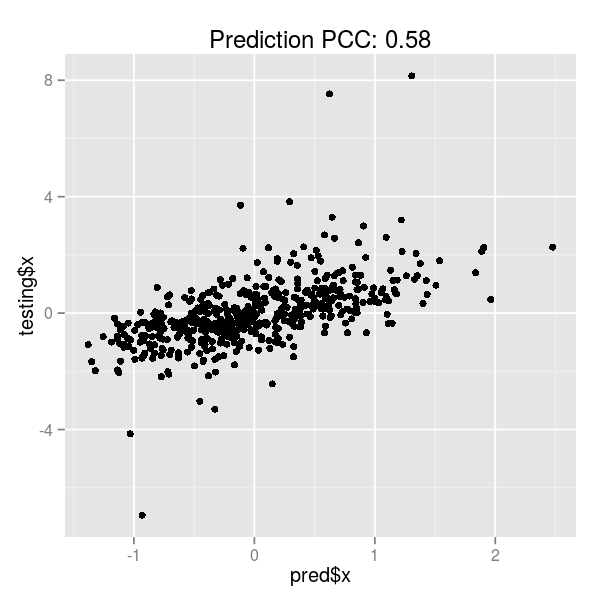

In [29]:
options(repr.plot.width=5, repr.plot.height=5)
# Baseline + Mutation + GUILD based predictions
pred = read.table(paste0(output.dir, "/ch1a_mut_guild/", "prediction.dat"))
a = cor(pred, testing)
print(sprintf("Correlation: %.2f", a[[1]]))
p = qplot(pred$x, testing$x, main = paste0("Prediction PCC: ", format(a, digits=2)))
print(p)

***Combined predictor without using monotherapy data (Mutation + GUILD)***

[1] "Correlation: 0.64"


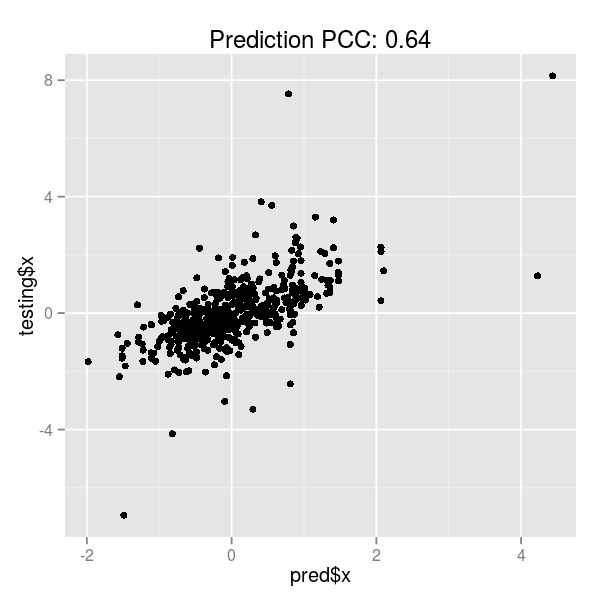

In [30]:
# Mutation + GUILD based predictions
pred = read.table(paste0(output.dir, "/ch1b_mut_guild/", "prediction.dat"))
a = cor(pred, testing)
print(sprintf("Correlation: %.2f", a[[1]]))
p = qplot(pred$x, testing$x, main = paste0("Prediction PCC: ", format(a, digits=2)))
print(p)

## Final predictors and confidence assignment

>***Predictor for subtask 1*** 
The best performing predictor using the response data uses mutation and GUILD based features and achieves an accuracy (assessed by correlation between predicted and observed synergy scores) of 0.58

>***Predictor for subtask 2*** 
Uses mutation and GUILD based features and achieves an accuracy (assessed by correlation between predicted and observed synergy scores) of 0.64
    
>***Confidence assignment***
We observed that the predictions tend to fail for higher synergy scores, accordingly we defined the following confidence scoring:
$$confidence = 1 - abs(synergy) / max(abs(synergy))$$

## TODO

***Incorporating pathway information***

Incorporating external data on relevant biological processes is key to improve the predictors. The expression and mutation data for the following genes are being considered as potential features:

- COSMIC / Futreal et al: 412 genes

- Oncogenes from Bansal et al: 71 genes

- KEGG pathways:
    * aminoacyl-tRNA biosynthesis
    * MAPK signaling pathway
    * NF-kappa B signaling pathway
    * Cell Cycle
    * p53 signaling pathway
    * Apoptosis
    * TGF-beta signaling pathway
    * Cancer pathways
        + thyroid cancer 29
        + bladder cancer 42
        + endometrial cancer 52
        + colorectal cancer 62
        + pancreatic cancer 70
        + small cell lung cancer 84
        + non small cell lung cancer 54
        + prostate cancer 89

***Incorporating drug similarity info***

If the drugs are similar, the effect is expected to be synergistic (i.e. Loewe additivity)

- chemical formula 
- common targets